# Step 7: Model Validation

**Objective:** Rigorously validate model performance using proper backtesting, cross-validation, and statistical tests.

## Validation Components:
1. **Time Series Cross-Validation** - Walk-forward validation
2. **Out-of-Sample Testing** - True holdout evaluation
3. **Statistical Significance** - Hypothesis testing
4. **Performance Metrics** - Comprehensive evaluation
5. **Stability Analysis** - Model consistency over time

## 7.1 Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler

# Models
from lightgbm import LGBMClassifier

# Statistical tests
from scipy import stats

# Technical indicators
import ta

# Paths
DATA_RAW = Path('../data/raw')
DATA_FEATURES = Path('../data/features')
PIPELINE_DIR = Path('../pipeline')
VALIDATION_DIR = Path('../validation')
VALIDATION_DIR.mkdir(exist_ok=True)

TICKERS = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'META', 'GOOGL']

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Libraries loaded')
print(f'📁 Validation directory: {VALIDATION_DIR.absolute()}')

✅ Libraries loaded
📁 Validation directory: c:\git\Data project\notebooks\..\validation


## 7.2 Load Pipeline and Prepare Data

In [2]:
# Import pipeline class from previous notebook
import sys
sys.path.append('..')

# Recreate the pipeline class for validation
class TechnicalIndicatorTransformer:
    def transform(self, df):
        df = df.copy()
        # Trend
        df['SMA_10'] = ta.trend.sma_indicator(df['close'], window=10)
        df['SMA_20'] = ta.trend.sma_indicator(df['close'], window=20)
        df['SMA_50'] = ta.trend.sma_indicator(df['close'], window=50)
        df['EMA_10'] = ta.trend.ema_indicator(df['close'], window=10)
        df['EMA_20'] = ta.trend.ema_indicator(df['close'], window=20)
        
        macd = ta.trend.MACD(df['close'])
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Hist'] = macd.macd_diff()
        
        adx = ta.trend.ADXIndicator(df['high'], df['low'], df['close'])
        df['ADX'] = adx.adx()
        df['ADX_Pos'] = adx.adx_pos()
        df['ADX_Neg'] = adx.adx_neg()
        
        # Momentum
        df['RSI'] = ta.momentum.rsi(df['close'], window=14)
        df['RSI_Fast'] = ta.momentum.rsi(df['close'], window=7)
        
        stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'])
        df['Stoch_K'] = stoch.stoch()
        df['Stoch_D'] = stoch.stoch_signal()
        
        df['ROC_5'] = ta.momentum.roc(df['close'], window=5)
        df['ROC_10'] = ta.momentum.roc(df['close'], window=10)
        
        # Volatility
        bb = ta.volatility.BollingerBands(df['close'])
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()
        df['BB_Mid'] = bb.bollinger_mavg()
        df['BB_Width'] = (df['BB_High'] - df['BB_Low']) / df['BB_Mid']
        df['BB_Pct'] = bb.bollinger_pband()
        
        df['ATR'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'])
        
        # Volume
        df['OBV'] = ta.volume.on_balance_volume(df['close'], df['volume'])
        df['Volume_SMA_20'] = df['volume'].rolling(20).mean()
        df['Volume_Ratio'] = df['volume'] / df['Volume_SMA_20']
        
        return df

def add_lag_features(df, columns=['Return', 'RSI', 'Volume_Ratio'], lags=[1, 2, 3, 5, 10, 20]):
    df = df.copy()
    if 'Return' not in df.columns:
        df['Return'] = df['close'].pct_change()
    for col in columns:
        if col in df.columns:
            for lag in lags:
                df[f'{col}_Lag_{lag}'] = df[col].shift(lag)
    return df

def add_rolling_stats(df, windows=[5, 10, 20]):
    df = df.copy()
    if 'Return' not in df.columns:
        df['Return'] = df['close'].pct_change()
    for window in windows:
        df[f'Return_Mean_{window}D'] = df['Return'].rolling(window).mean()
        df[f'Return_Std_{window}D'] = df['Return'].rolling(window).std()
        df[f'Sharpe_{window}D'] = df[f'Return_Mean_{window}D'] / (df[f'Return_Std_{window}D'] + 1e-10)
        df[f'Volatility_{window}D'] = df['close'].pct_change().rolling(window).std() * np.sqrt(252)
        df[f'Price_Range_{window}D'] = (df['high'].rolling(window).max() - df['low'].rolling(window).min()) / df['close']
    return df

def prepare_features(df):
    """Complete feature engineering pipeline."""
    transformer = TechnicalIndicatorTransformer()
    df = transformer.transform(df)
    df = add_lag_features(df)
    df = add_rolling_stats(df)
    
    # Add target
    df['Future_Return'] = df['close'].pct_change(1).shift(-1)
    df['Target'] = (df['Future_Return'] > 0).astype(int)
    
    return df

print('✅ Feature engineering functions defined')

✅ Feature engineering functions defined


In [3]:
# Load and prepare data for validation
def load_stock_data(ticker):
    file_path = DATA_RAW / f'{ticker}_raw.csv'
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df.columns = df.columns.str.lower()
    df = prepare_features(df)
    return df

# Load all stock data
stock_data = {}
for ticker in TICKERS:
    stock_data[ticker] = load_stock_data(ticker)
    print(f"✅ {ticker}: {len(stock_data[ticker])} rows")

print(f"\n📊 Total: {sum(len(df) for df in stock_data.values())} rows across {len(TICKERS)} stocks")

✅ AAPL: 2021 rows
✅ MSFT: 2021 rows
✅ NVDA: 2021 rows
✅ TSLA: 2021 rows
✅ AMZN: 2021 rows
✅ META: 2021 rows
✅ GOOGL: 2021 rows

📊 Total: 14147 rows across 7 stocks


## 7.3 Time Series Cross-Validation

In [4]:
def get_feature_columns(df):
    """Get feature columns for modeling."""
    exclude = ['open', 'high', 'low', 'close', 'volume', 'adj close',
               'Target', 'Future_Return', 'date', 'Date', 'ticker', 'Ticker']
    return [col for col in df.select_dtypes(include=[np.number]).columns
            if col not in exclude]

def time_series_cv(df, n_splits=5):
    """
    Perform time series cross-validation.
    
    Returns metrics for each fold.
    """
    feature_cols = get_feature_columns(df)
    df_clean = df.dropna(subset=feature_cols + ['Target'])
    
    X = df_clean[feature_cols].values
    y = df_clean['Target'].values
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    results = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train
        model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, 
                               random_state=42, verbosity=-1)
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        # Metrics
        fold_results = {
            'Fold': fold,
            'Train_Size': len(train_idx),
            'Test_Size': len(test_idx),
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'AUC': roc_auc_score(y_test, y_prob)
        }
        results.append(fold_results)
    
    return pd.DataFrame(results)

print('✅ Time series CV function defined')

✅ Time series CV function defined


In [5]:
# Run time series cross-validation for each stock
print('=' * 70)
print('📊 TIME SERIES CROSS-VALIDATION (5 FOLDS)')
print('=' * 70)

cv_results = {}

for ticker in TICKERS:
    print(f"\n{ticker}:")
    cv_results[ticker] = time_series_cv(stock_data[ticker], n_splits=5)
    
    # Summary
    mean_acc = cv_results[ticker]['Accuracy'].mean()
    std_acc = cv_results[ticker]['Accuracy'].std()
    mean_auc = cv_results[ticker]['AUC'].mean()
    
    print(f"   Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"   AUC: {mean_auc:.4f}")

📊 TIME SERIES CROSS-VALIDATION (5 FOLDS)

AAPL:
   Accuracy: 0.4823 ± 0.0453
   AUC: 0.4998

MSFT:
   Accuracy: 0.5098 ± 0.0271
   AUC: 0.5232

NVDA:
   Accuracy: 0.4988 ± 0.0266
   AUC: 0.5247

TSLA:
   Accuracy: 0.4921 ± 0.0334
   AUC: 0.5148

AMZN:
   Accuracy: 0.4774 ± 0.0207
   AUC: 0.4833

META:
   Accuracy: 0.5018 ± 0.0312
   AUC: 0.5156

GOOGL:
   Accuracy: 0.4976 ± 0.0297
   AUC: 0.5170


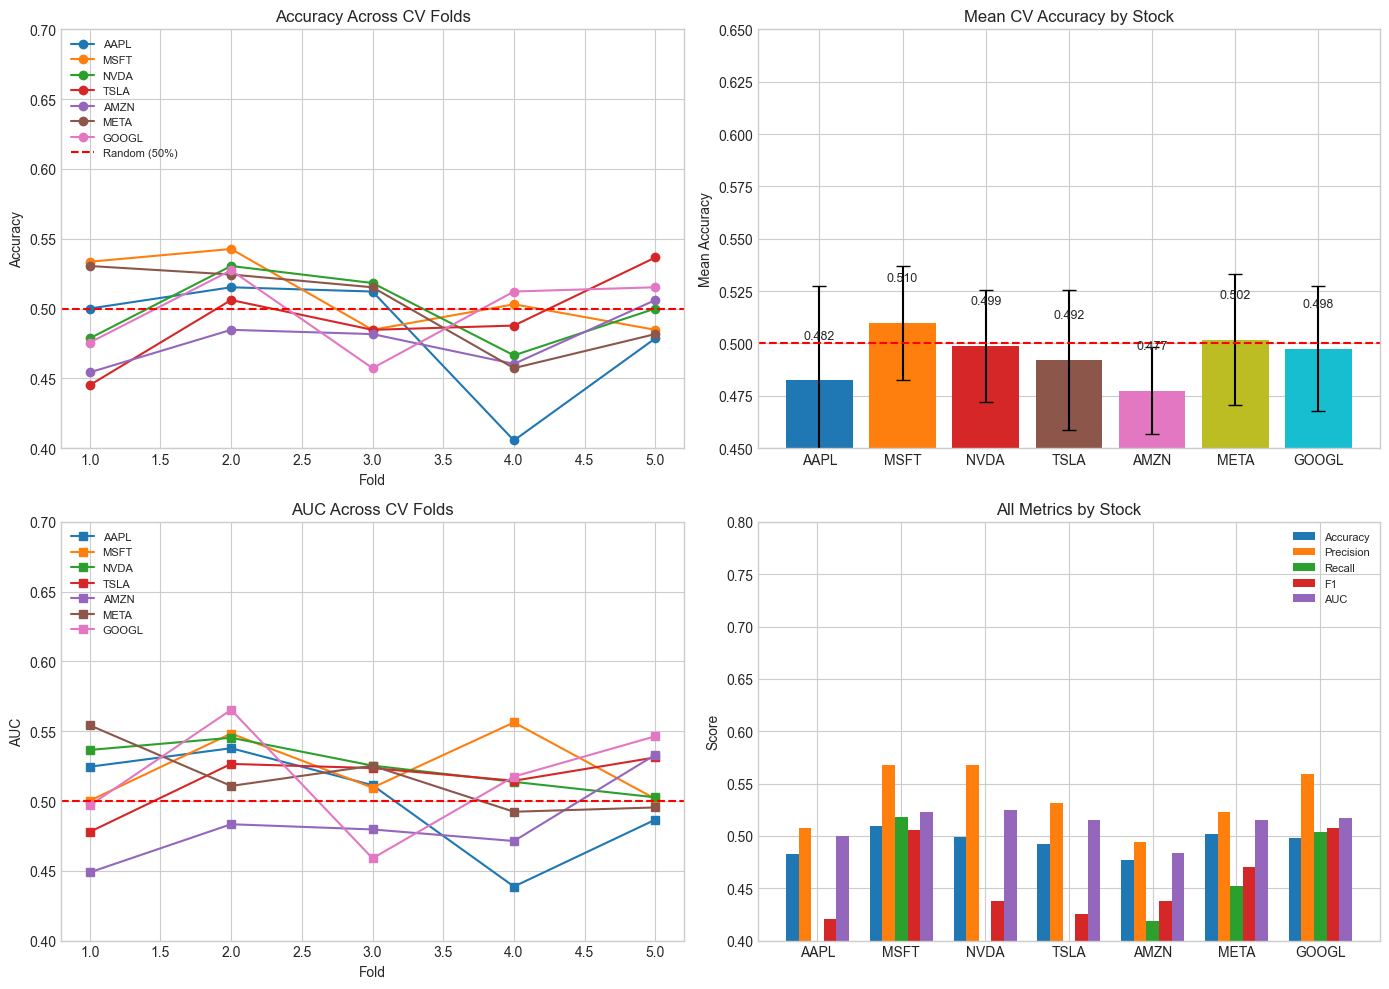

📊 Saved: validation/cv_results.png


In [6]:
# Visualize CV results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Accuracy by fold for each stock
ax = axes[0, 0]
for ticker in TICKERS:
    ax.plot(cv_results[ticker]['Fold'], cv_results[ticker]['Accuracy'], 
            marker='o', label=ticker)
ax.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Across CV Folds')
ax.legend(loc='upper left', fontsize=8)
ax.set_ylim(0.4, 0.7)

# 2. Mean accuracy comparison
ax = axes[0, 1]
mean_accuracies = [cv_results[t]['Accuracy'].mean() for t in TICKERS]
std_accuracies = [cv_results[t]['Accuracy'].std() for t in TICKERS]
colors = plt.cm.tab10(np.linspace(0, 1, len(TICKERS)))
bars = ax.bar(TICKERS, mean_accuracies, yerr=std_accuracies, color=colors, capsize=5)
ax.axhline(0.5, color='red', linestyle='--')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean CV Accuracy by Stock')
ax.set_ylim(0.45, 0.65)
for bar, acc in zip(bars, mean_accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{acc:.3f}', ha='center', fontsize=9)

# 3. AUC by fold
ax = axes[1, 0]
for ticker in TICKERS:
    ax.plot(cv_results[ticker]['Fold'], cv_results[ticker]['AUC'], 
            marker='s', label=ticker)
ax.axhline(0.5, color='red', linestyle='--')
ax.set_xlabel('Fold')
ax.set_ylabel('AUC')
ax.set_title('AUC Across CV Folds')
ax.legend(loc='upper left', fontsize=8)
ax.set_ylim(0.4, 0.7)

# 4. All metrics comparison
ax = axes[1, 1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x = np.arange(len(TICKERS))
width = 0.15
for i, metric in enumerate(metrics):
    values = [cv_results[t][metric].mean() for t in TICKERS]
    ax.bar(x + i*width, values, width, label=metric)
ax.set_xticks(x + width * 2)
ax.set_xticklabels(TICKERS)
ax.set_ylabel('Score')
ax.set_title('All Metrics by Stock')
ax.legend(loc='upper right', fontsize=8)
ax.set_ylim(0.4, 0.8)

plt.tight_layout()
plt.savefig(VALIDATION_DIR / 'cv_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: validation/cv_results.png')

## 7.4 Walk-Forward Validation (Out-of-Sample)

In [7]:
def walk_forward_validation(df, train_window=252, test_window=21):
    """
    Walk-forward validation simulating real trading.
    
    Parameters:
    -----------
    train_window : int
        Number of days for training (default: 1 year)
    test_window : int
        Number of days for testing (default: 1 month)
    """
    feature_cols = get_feature_columns(df)
    df_clean = df.dropna(subset=feature_cols + ['Target']).copy()
    
    results = []
    predictions_all = []
    
    n_samples = len(df_clean)
    start_idx = train_window
    
    while start_idx + test_window <= n_samples:
        # Define train/test split
        train_start = start_idx - train_window
        train_end = start_idx
        test_end = min(start_idx + test_window, n_samples)
        
        # Get data
        train_data = df_clean.iloc[train_start:train_end]
        test_data = df_clean.iloc[train_end:test_end]
        
        X_train = train_data[feature_cols].values
        y_train = train_data['Target'].values
        X_test = test_data[feature_cols].values
        y_test = test_data['Target'].values
        
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                               random_state=42, verbosity=-1)
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        # Store predictions with dates
        for i, (idx, row) in enumerate(test_data.iterrows()):
            predictions_all.append({
                'Date': idx,
                'Actual': y_test[i],
                'Predicted': y_pred[i],
                'Probability': y_prob[i]
            })
        
        # Calculate metrics for this window
        if len(np.unique(y_test)) > 1:
            auc = roc_auc_score(y_test, y_prob)
        else:
            auc = 0.5
            
        results.append({
            'Window_Start': test_data.index[0],
            'Window_End': test_data.index[-1],
            'Accuracy': accuracy_score(y_test, y_pred),
            'AUC': auc,
            'N_Samples': len(y_test)
        })
        
        # Move forward
        start_idx += test_window
    
    return pd.DataFrame(results), pd.DataFrame(predictions_all)

print('✅ Walk-forward validation function defined')

✅ Walk-forward validation function defined


In [8]:
# Run walk-forward validation
print('=' * 70)
print('📊 WALK-FORWARD VALIDATION (1Y Train, 1M Test Windows)')
print('=' * 70)

wf_results = {}
wf_predictions = {}

for ticker in TICKERS:
    print(f"\nProcessing {ticker}...")
    wf_results[ticker], wf_predictions[ticker] = walk_forward_validation(
        stock_data[ticker], train_window=252, test_window=21
    )
    
    mean_acc = wf_results[ticker]['Accuracy'].mean()
    mean_auc = wf_results[ticker]['AUC'].mean()
    n_windows = len(wf_results[ticker])
    
    print(f"   Windows: {n_windows}")
    print(f"   Mean Accuracy: {mean_acc:.4f}")
    print(f"   Mean AUC: {mean_auc:.4f}")

📊 WALK-FORWARD VALIDATION (1Y Train, 1M Test Windows)

Processing AAPL...
   Windows: 81
   Mean Accuracy: 0.5068
   Mean AUC: 0.5503

Processing MSFT...
   Windows: 81
   Mean Accuracy: 0.5168
   Mean AUC: 0.5298

Processing NVDA...
   Windows: 81
   Mean Accuracy: 0.5109
   Mean AUC: 0.5494

Processing TSLA...
   Windows: 81
   Mean Accuracy: 0.4780
   Mean AUC: 0.5147

Processing AMZN...
   Windows: 81
   Mean Accuracy: 0.4938
   Mean AUC: 0.5171

Processing META...
   Windows: 81
   Mean Accuracy: 0.5115
   Mean AUC: 0.5541

Processing GOOGL...
   Windows: 81
   Mean Accuracy: 0.5203
   Mean AUC: 0.5446


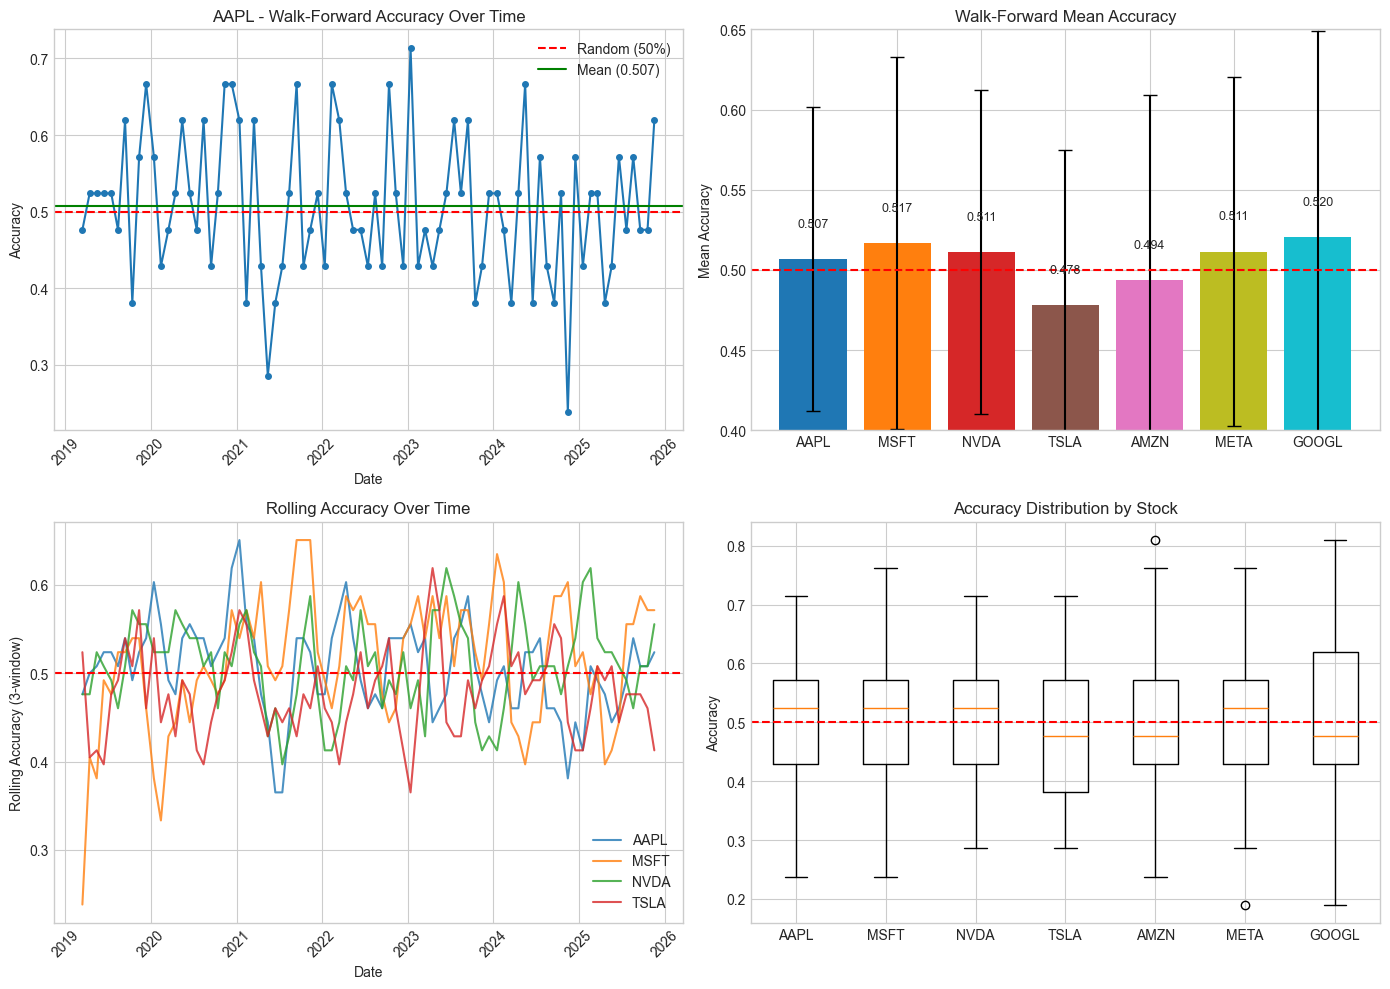

📊 Saved: validation/walk_forward_results.png


In [9]:
# Visualize walk-forward results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Accuracy over time for AAPL
ax = axes[0, 0]
ticker = 'AAPL'
ax.plot(wf_results[ticker]['Window_Start'], wf_results[ticker]['Accuracy'], 
        marker='o', markersize=4)
ax.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax.axhline(wf_results[ticker]['Accuracy'].mean(), color='green', linestyle='-', 
           label=f'Mean ({wf_results[ticker]["Accuracy"].mean():.3f})')
ax.set_xlabel('Date')
ax.set_ylabel('Accuracy')
ax.set_title(f'{ticker} - Walk-Forward Accuracy Over Time')
ax.legend()
ax.tick_params(axis='x', rotation=45)

# 2. Mean accuracy comparison across stocks
ax = axes[0, 1]
mean_wf_acc = [wf_results[t]['Accuracy'].mean() for t in TICKERS]
std_wf_acc = [wf_results[t]['Accuracy'].std() for t in TICKERS]
bars = ax.bar(TICKERS, mean_wf_acc, yerr=std_wf_acc, color=colors, capsize=5)
ax.axhline(0.5, color='red', linestyle='--')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Walk-Forward Mean Accuracy')
ax.set_ylim(0.4, 0.65)
for bar, acc in zip(bars, mean_wf_acc):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{acc:.3f}', ha='center', fontsize=9)

# 3. Rolling accuracy (all stocks combined)
ax = axes[1, 0]
for ticker in TICKERS[:4]:  # First 4 stocks
    rolling_acc = wf_results[ticker]['Accuracy'].rolling(3, min_periods=1).mean()
    ax.plot(wf_results[ticker]['Window_Start'], rolling_acc, label=ticker, alpha=0.8)
ax.axhline(0.5, color='red', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Rolling Accuracy (3-window)')
ax.set_title('Rolling Accuracy Over Time')
ax.legend()
ax.tick_params(axis='x', rotation=45)

# 4. Accuracy distribution
ax = axes[1, 1]
all_accuracies = []
labels = []
for ticker in TICKERS:
    all_accuracies.append(wf_results[ticker]['Accuracy'].values)
    labels.append(ticker)
ax.boxplot(all_accuracies, labels=labels)
ax.axhline(0.5, color='red', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Distribution by Stock')

plt.tight_layout()
plt.savefig(VALIDATION_DIR / 'walk_forward_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: validation/walk_forward_results.png')

## 7.5 Statistical Significance Tests

In [10]:
# Test if model performance is significantly better than random
print('=' * 70)
print('📊 STATISTICAL SIGNIFICANCE TESTS')
print('=' * 70)

significance_results = []

for ticker in TICKERS:
    # Get predictions
    preds = wf_predictions[ticker]
    
    # Calculate accuracy
    correct = (preds['Actual'] == preds['Predicted']).sum()
    total = len(preds)
    accuracy = correct / total
    
    # Binomial test: Is accuracy significantly different from 0.5?
    # H0: p = 0.5 (random guessing)
    # H1: p > 0.5 (better than random)
    binom_result = stats.binomtest(correct, total, p=0.5, alternative='greater')
    
    # One-sample t-test on window accuracies
    window_accs = wf_results[ticker]['Accuracy'].values
    t_stat, t_pval = stats.ttest_1samp(window_accs, 0.5)
    
    significance_results.append({
        'Ticker': ticker,
        'N_Predictions': total,
        'Accuracy': accuracy,
        'Binom_P_Value': binom_result.pvalue,
        'T_Stat': t_stat,
        'T_P_Value': t_pval / 2,  # One-tailed
        'Significant_5%': binom_result.pvalue < 0.05
    })

sig_df = pd.DataFrame(significance_results)
print("\n" + sig_df.to_string(index=False))

# Summary
n_significant = sig_df['Significant_5%'].sum()
print(f"\n📊 {n_significant}/{len(TICKERS)} stocks show statistically significant improvement over random (p < 0.05)")

📊 STATISTICAL SIGNIFICANCE TESTS

Ticker  N_Predictions  Accuracy  Binom_P_Value    T_Stat  T_P_Value  Significant_5%
  AAPL           1701  0.506761       0.296877  0.642293   0.261260           False
  MSFT           1701  0.516755       0.087255  1.303389   0.098090           False
  NVDA           1701  0.510876       0.191369  0.968965   0.167742           False
  TSLA           1701  0.477954       0.967331 -2.048767   0.021882           False
  AMZN           1701  0.493827       0.703123 -0.480875   0.315959           False
  META           1701  0.511464       0.178432  0.948375   0.172897           False
 GOOGL           1701  0.520282       0.049584  1.421759   0.079492            True

📊 1/7 stocks show statistically significant improvement over random (p < 0.05)


In [11]:
# Wilcoxon signed-rank test: Compare model vs random baseline
print('\n' + '=' * 70)
print('📊 WILCOXON SIGNED-RANK TEST (vs Random Baseline)')
print('=' * 70)

# Combine all window accuracies
all_window_accs = []
for ticker in TICKERS:
    all_window_accs.extend(wf_results[ticker]['Accuracy'].values)

all_window_accs = np.array(all_window_accs)

# Wilcoxon test vs 0.5
stat, pval = stats.wilcoxon(all_window_accs - 0.5, alternative='greater')

print(f"\nAll stocks combined:")
print(f"   N windows: {len(all_window_accs)}")
print(f"   Mean accuracy: {all_window_accs.mean():.4f}")
print(f"   Median accuracy: {np.median(all_window_accs):.4f}")
print(f"   Wilcoxon statistic: {stat:.2f}")
print(f"   P-value: {pval:.4f}")
print(f"   Significant (p < 0.05): {'Yes ✓' if pval < 0.05 else 'No'}")


📊 WILCOXON SIGNED-RANK TEST (vs Random Baseline)

All stocks combined:
   N windows: 567
   Mean accuracy: 0.5054
   Median accuracy: 0.5238
   Wilcoxon statistic: 81502.00
   P-value: 0.3995
   Significant (p < 0.05): No


## 7.6 Model Stability Analysis

In [12]:
# Analyze model stability over different market conditions
print('=' * 70)
print('📊 MODEL STABILITY ANALYSIS')
print('=' * 70)

stability_results = []

for ticker in TICKERS:
    df = stock_data[ticker]
    wf = wf_results[ticker]
    
    # Calculate market returns during each window
    market_returns = []
    for _, row in wf.iterrows():
        mask = (df.index >= row['Window_Start']) & (df.index <= row['Window_End'])
        window_data = df[mask]
        if len(window_data) > 0:
            ret = (window_data['close'].iloc[-1] / window_data['close'].iloc[0]) - 1
            market_returns.append(ret)
        else:
            market_returns.append(0)
    
    wf_copy = wf.copy()
    wf_copy['Market_Return'] = market_returns
    wf_copy['Market_Regime'] = np.where(wf_copy['Market_Return'] > 0, 'Bull', 'Bear')
    
    # Accuracy by regime
    bull_acc = wf_copy[wf_copy['Market_Regime'] == 'Bull']['Accuracy'].mean()
    bear_acc = wf_copy[wf_copy['Market_Regime'] == 'Bear']['Accuracy'].mean()
    
    stability_results.append({
        'Ticker': ticker,
        'Overall_Acc': wf['Accuracy'].mean(),
        'Bull_Acc': bull_acc,
        'Bear_Acc': bear_acc,
        'Acc_Std': wf['Accuracy'].std(),
        'Stability_Score': 1 - wf['Accuracy'].std()  # Higher is more stable
    })

stability_df = pd.DataFrame(stability_results)
print("\n" + stability_df.to_string(index=False))

📊 MODEL STABILITY ANALYSIS

Ticker  Overall_Acc  Bull_Acc  Bear_Acc  Acc_Std  Stability_Score
  AAPL     0.506761  0.509434  0.501701 0.094733         0.905267
  MSFT     0.516755  0.516190  0.517665 0.115693         0.884307
  NVDA     0.510876  0.506410  0.518883 0.101019         0.898981
  TSLA     0.477954  0.471958  0.485450 0.096845         0.903155
  AMZN     0.493827  0.519048  0.453149 0.115530         0.884470
  META     0.511464  0.506173  0.522046 0.108791         0.891209
 GOOGL     0.520282  0.522817  0.516595 0.128390         0.871610


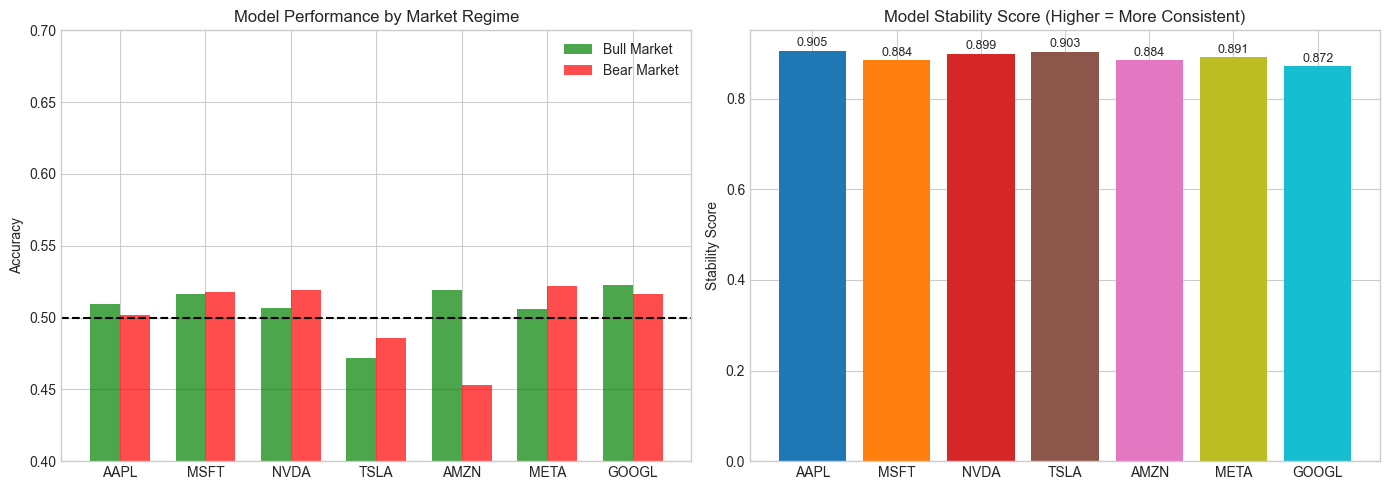

📊 Saved: validation/stability_analysis.png


In [13]:
# Visualize stability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Bull vs Bear performance
ax = axes[0]
x = np.arange(len(TICKERS))
width = 0.35
ax.bar(x - width/2, stability_df['Bull_Acc'], width, label='Bull Market', color='green', alpha=0.7)
ax.bar(x + width/2, stability_df['Bear_Acc'], width, label='Bear Market', color='red', alpha=0.7)
ax.axhline(0.5, color='black', linestyle='--')
ax.set_xticks(x)
ax.set_xticklabels(TICKERS)
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance by Market Regime')
ax.legend()
ax.set_ylim(0.4, 0.7)

# 2. Stability scores
ax = axes[1]
bars = ax.bar(TICKERS, stability_df['Stability_Score'], color=colors)
ax.set_ylabel('Stability Score')
ax.set_title('Model Stability Score (Higher = More Consistent)')
for bar, score in zip(bars, stability_df['Stability_Score']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{score:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(VALIDATION_DIR / 'stability_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: validation/stability_analysis.png')

## 7.7 Confusion Matrix Analysis

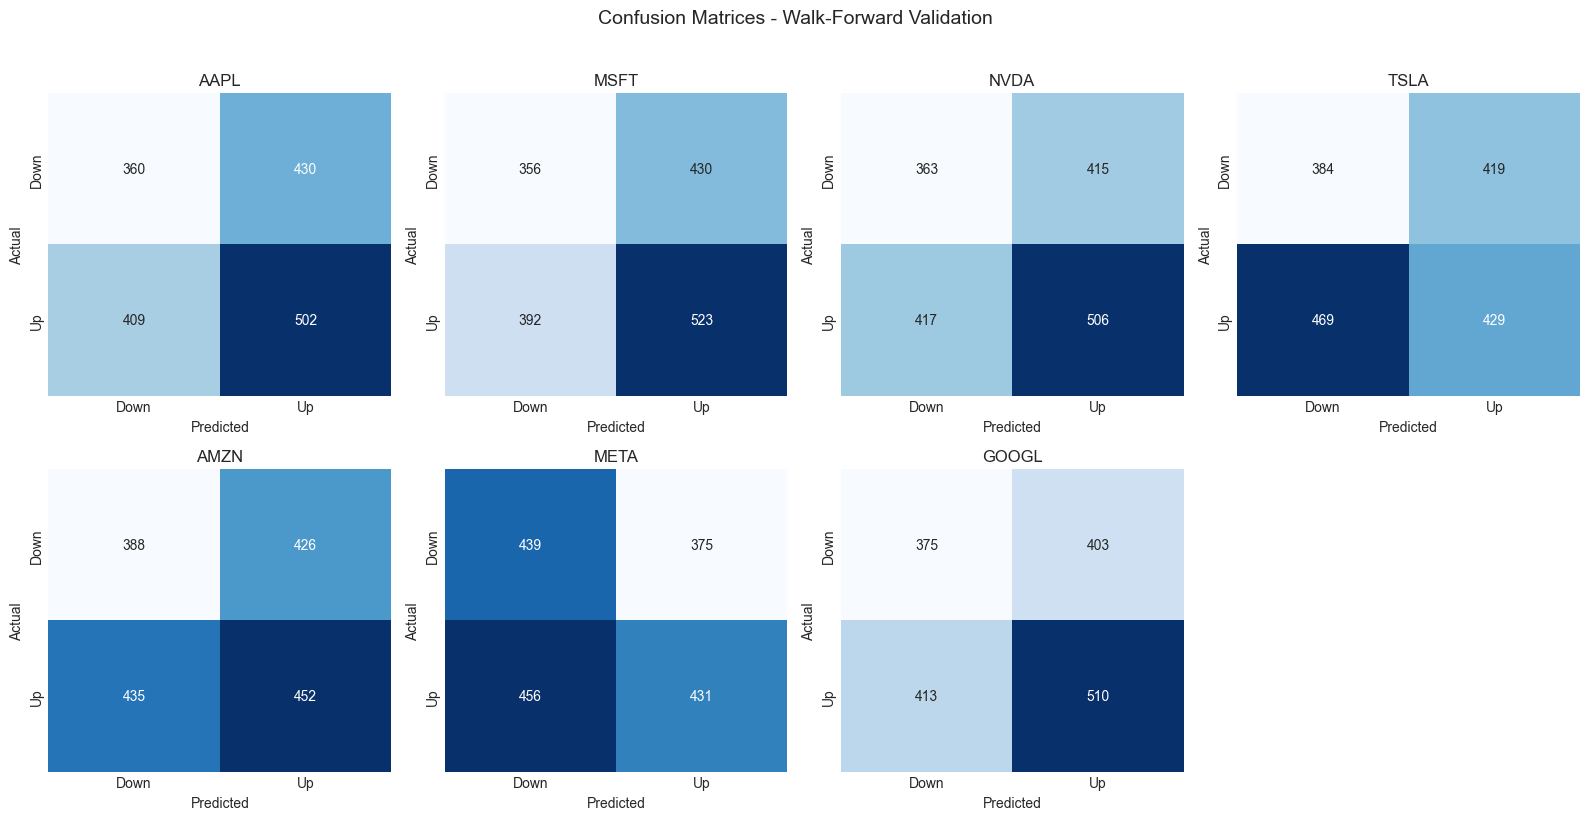

📊 Saved: validation/confusion_matrices.png


In [14]:
# Detailed confusion matrix for each stock
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    preds = wf_predictions[ticker]
    cm = confusion_matrix(preds['Actual'], preds['Predicted'])
    
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{ticker}')
    ax.set_xticklabels(['Down', 'Up'])
    ax.set_yticklabels(['Down', 'Up'])

# Hide last subplot
axes[-1].axis('off')

plt.suptitle('Confusion Matrices - Walk-Forward Validation', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(VALIDATION_DIR / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: validation/confusion_matrices.png')

## 7.8 Validation Summary

In [15]:
# Save validation results
validation_summary = {
    'cv_results': {ticker: cv_results[ticker].to_dict() for ticker in TICKERS},
    'walk_forward_summary': {
        ticker: {
            'mean_accuracy': float(wf_results[ticker]['Accuracy'].mean()),
            'std_accuracy': float(wf_results[ticker]['Accuracy'].std()),
            'mean_auc': float(wf_results[ticker]['AUC'].mean()),
            'n_windows': len(wf_results[ticker])
        } for ticker in TICKERS
    },
    'statistical_tests': sig_df.to_dict(orient='records'),
    'stability_analysis': stability_df.to_dict(orient='records'),
    'validation_date': datetime.now().isoformat()
}

with open(VALIDATION_DIR / 'validation_summary.json', 'w') as f:
    json.dump(validation_summary, f, indent=2, default=str)

print('💾 Saved: validation/validation_summary.json')

💾 Saved: validation/validation_summary.json


In [16]:
# Final Summary
print('=' * 70)
print('📋 VALIDATION SUMMARY')
print('=' * 70)

print("\n📊 CROSS-VALIDATION RESULTS:")
print("-" * 50)
for ticker in TICKERS:
    mean_acc = cv_results[ticker]['Accuracy'].mean()
    std_acc = cv_results[ticker]['Accuracy'].std()
    print(f"   {ticker}: {mean_acc:.4f} ± {std_acc:.4f}")

print("\n📊 WALK-FORWARD VALIDATION:")
print("-" * 50)
for ticker in TICKERS:
    mean_acc = wf_results[ticker]['Accuracy'].mean()
    print(f"   {ticker}: {mean_acc:.4f}")

print("\n📊 STATISTICAL SIGNIFICANCE:")
print("-" * 50)
n_sig = sig_df['Significant_5%'].sum()
print(f"   {n_sig}/{len(TICKERS)} stocks significantly better than random (p < 0.05)")

print("\n📊 OVERALL PERFORMANCE:")
print("-" * 50)
overall_acc = np.mean([wf_results[t]['Accuracy'].mean() for t in TICKERS])
best_ticker = max(TICKERS, key=lambda t: wf_results[t]['Accuracy'].mean())
print(f"   Average Accuracy: {overall_acc:.4f}")
print(f"   Best Performer: {best_ticker} ({wf_results[best_ticker]['Accuracy'].mean():.4f})")

print("\n📁 FILES SAVED:")
print("-" * 50)
print("   • validation/cv_results.png")
print("   • validation/walk_forward_results.png")
print("   • validation/stability_analysis.png")
print("   • validation/confusion_matrices.png")
print("   • validation/validation_summary.json")

print("\n" + '=' * 70)
print('✅ STEP 7 COMPLETE - Ready for 08_optimization.ipynb')
print('=' * 70)

📋 VALIDATION SUMMARY

📊 CROSS-VALIDATION RESULTS:
--------------------------------------------------
   AAPL: 0.4823 ± 0.0453
   MSFT: 0.5098 ± 0.0271
   NVDA: 0.4988 ± 0.0266
   TSLA: 0.4921 ± 0.0334
   AMZN: 0.4774 ± 0.0207
   META: 0.5018 ± 0.0312
   GOOGL: 0.4976 ± 0.0297

📊 WALK-FORWARD VALIDATION:
--------------------------------------------------
   AAPL: 0.5068
   MSFT: 0.5168
   NVDA: 0.5109
   TSLA: 0.4780
   AMZN: 0.4938
   META: 0.5115
   GOOGL: 0.5203

📊 STATISTICAL SIGNIFICANCE:
--------------------------------------------------
   1/7 stocks significantly better than random (p < 0.05)

📊 OVERALL PERFORMANCE:
--------------------------------------------------
   Average Accuracy: 0.5054
   Best Performer: GOOGL (0.5203)

📁 FILES SAVED:
--------------------------------------------------
   • validation/cv_results.png
   • validation/walk_forward_results.png
   • validation/stability_analysis.png
   • validation/confusion_matrices.png
   • validation/validation_summary.json